In [ ]:
import torch
import torch.nn as nn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

Dataset Set-up

In [ ]:
import kagglehub

# Download latest version
data_path = kagglehub.dataset_download("oladayoluke/enhanced-sign-language-mnist-dataset")

print("Path to dataset files:", data_path)

100%|██████████| 46.1M/46.1M [00:00<00:00, 155MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/oladayoluke/enhanced-sign-language-mnist-dataset/versions/1


In [ ]:
k_train_file = os.path.join(data_path, "k_train.csv")
if os.path.isfile(k_train_file):
    print("grabbing k_train_file")
else:
    print("Unable to read k_train_file")
k_train = pd.read_csv(k_train_file)
print(k_train.shape[0])


k_test_file = os.path.join(data_path, "k_test.csv")
if os.path.isfile(k_test_file):
    print("grabbing k_test_file")
else:
    print("Unable to read k_test_file")
k_test = pd.read_csv(k_test_file)
print(k_test.shape[0])

g_train_file = os.path.join(data_path, "g_train.csv")
if os.path.isfile(g_train_file):
    print("grabbing g_train_file")
else:
    print("Unable to read g_train_file")
g_train = pd.read_csv(g_train_file)
print(g_train.shape[0])


g_test_file = os.path.join(data_path, "g_test.csv")
if os.path.isfile(g_test_file):
    print("grabbing g_test_file")
else:
    print("Unable to read g_test_file")
g_test = pd.read_csv(g_test_file)
print(g_test.shape[0])

grabbing k_train_file
27700
grabbing k_test_file
6925
grabbing g_train_file
27700
grabbing g_test_file
6925


In [ ]:
enhanced_train =  pd.concat([k_train, g_train], axis=0, ignore_index=True).sample(frac=1)
enhanced_test =  pd.concat([k_test, g_test], axis=0, ignore_index=True).sample(frac=1)

X_train = enhanced_train[list(enhanced_train)[1:]].values
y_train = enhanced_train.label.values
X_test = enhanced_test[list(enhanced_test)[1:]].values
y_test = enhanced_test.label.values

#genrated test samples
xg_test=g_test.iloc[:,1:].values
yg_test=g_test.iloc[:,0].values
yg_test = yg_test.astype('int')

#split validation samples out of train samples
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(44320, 784)
(11080, 784)
(13850, 784)


Testing Dataset

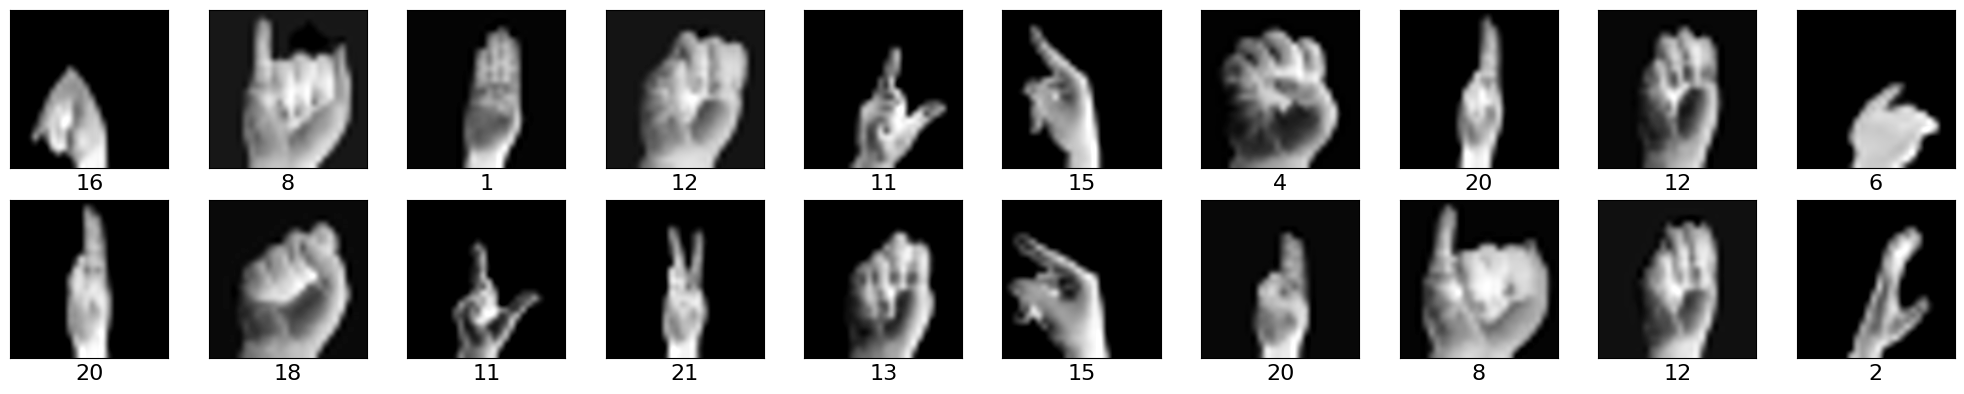

In [ ]:
def displayImages(images, labels, nCols=10):
    """Displays images with labels (nCols per row)
    - images: list of images
    - labels: list of labels for images"""
    nRows = np.ceil(len(labels)/nCols).astype('int') # number of rows
    plt.figure(figsize=(2*nCols,2*nRows)) # figure size
    for i in range(len(labels)):
        plt.subplot(nRows,nCols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], interpolation='spline16', cmap='gray_r')
        plt.xlabel(str(labels[i]), fontsize=16)
    plt.tight_layout()
    plt.show()
    return

# show the first 20 generated test images
yg_test = g_test.label.values
xg_test = g_test[list(g_test)[1:]].values.reshape(-1, 28, 28, 1)
images = xg_test[:20]
labels = yg_test[:20]
displayImages(images, labels)

ResNet-18 with no skip connections

In [ ]:
class ResNet18_NoSkips(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.relu = nn.ReLU(inplace=True)

        # BLOCK 1
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        # BLOCK 2 (layer1)
        self.conv2_1_1 = nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=False)
        self.bn2_1_1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=False)
        self.bn2_1_2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv2_2_1 = nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=False)
        self.bn2_2_1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2_2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=False)
        self.bn2_2_2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # BLOCK 3 (layer2)
        self.conv3_1_1 = nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False)
        self.bn3_1_1 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_1_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False)
        self.bn3_1_2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv3_2_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False)
        self.bn3_2_1 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv3_2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1, bias=False)
        self.bn3_2_2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # BLOCK 4 (layer3)
        self.conv4_1_1 = nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False)
        self.bn4_1_1 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_1_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False)
        self.bn4_1_2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv4_2_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False)
        self.bn4_2_1 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv4_2_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False)
        self.bn4_2_2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # BLOCK 5 (layer4)
        self.conv5_1_1 = nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=False)
        self.bn5_1_1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_1_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1, bias=False)
        self.bn5_1_2 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.conv5_2_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1, bias=False)
        self.bn5_2_1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv5_2_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1, bias=False)
        self.bn5_2_2 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # CLASSIFIER
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, n_classes)


    def forward(self, x):

        # BLOCK 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # BLOCK 2 (layer1)
        x = self.conv2_1_1(x)
        x = self.bn2_1_1(x)
        x = self.relu(x)
        x = self.conv2_1_2(x)
        x = self.bn2_1_2(x)
        x = self.relu(x)

        x = self.conv2_2_1(x)
        x = self.bn2_2_1(x)
        x = self.relu(x)
        x = self.conv2_2_2(x)
        x = self.bn2_2_2(x)
        x = self.relu(x)

        # BLOCK 3 (layer2)
        x = self.conv3_1_1(x)
        x = self.bn3_1_1(x)
        x = self.relu(x)
        x = self.conv3_1_2(x)
        x = self.bn3_1_2(x)
        x = self.relu(x)

        x = self.conv3_2_1(x)
        x = self.bn3_2_1(x)
        x = self.relu(x)
        x = self.conv3_2_2(x)
        x = self.bn3_2_2(x)
        x = self.relu(x)

        # BLOCK 4 (layer3)
        x = self.conv4_1_1(x)
        x = self.bn4_1_1(x)
        x = self.relu(x)
        x = self.conv4_1_2(x)
        x = self.bn4_1_2(x)
        x = self.relu(x)

        x = self.conv4_2_1(x)
        x = self.bn4_2_1(x)
        x = self.relu(x)
        x = self.conv4_2_2(x)
        x = self.bn4_2_2(x)
        x = self.relu(x)

        # BLOCK 5 (layer4)
        x = self.conv5_1_1(x)
        x = self.bn5_1_1(x)
        x = self.relu(x)
        x = self.conv5_1_2(x)
        x = self.bn5_1_2(x)
        x = self.relu(x)

        x = self.conv5_2_1(x)
        x = self.bn5_2_1(x)
        x = self.relu(x)
        x = self.conv5_2_2(x)
        x = self.bn5_2_2(x)
        x = self.relu(x)

        # CLASSIFIER
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
resnet_without_skips = ResNet18_NoSkips(26)

In [ ]:
print(resnet_without_skips.parameters)

<bound method Module.parameters of ResNet18_NoSkips(
  (relu): ReLU(inplace=True)
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2_1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2_1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2_1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2_2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

ResNet-18 with skip connections

In [ ]:
from torchvision.models import resnet18

resnet_with_skips = resnet18()
resnet_with_skips.fc = nn.Linear(resnet_with_skips.fc.in_features, 26)

In [ ]:
print(resnet_with_skips.parameters)

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
import torch.nn.functional as F

In [ ]:
img = torch.tensor(X_train[0].reshape(1, 1, 28, 28)).float()
img = img.repeat(1, 3, 1, 1)
img = F.interpolate(img, size=(224, 224))

In [ ]:
resnet_without_skips(img)

tensor([[ 0.3639, -0.2774,  0.0358,  0.0117,  0.1419, -0.2629, -0.0388,  0.4343,
          0.1324, -0.4230,  0.2358,  0.1766,  0.3049, -0.2355,  0.0260, -0.0763,
         -0.2227, -0.2534, -0.3779,  0.1460,  0.2665,  0.2239,  0.5112, -0.2187,
          0.2626, -0.2438]], grad_fn=<AddmmBackward0>)

In [ ]:
resnet_with_skips(img)

tensor([[-0.0363,  1.2791, -0.7010,  0.4453,  0.2563,  0.2551, -0.3819,  0.7629,
          0.5057,  0.3622,  0.2498, -0.1740,  0.0088, -0.0070,  0.2434, -0.8273,
         -0.3530, -0.2919, -0.5613, -0.4125, -0.2862, -0.0407,  0.2259, -0.1773,
          0.4967,  0.5927]], grad_fn=<AddmmBackward0>)